In [1]:
%matplotlib inline

import email.parser
import email.policy
import os

In [2]:
# import os
# import tarfile
# from six.moves import urllib

# DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
# HAM_URL = DOWNLOAD_ROOT + "20021010_hard_ham.tar.bz2"
# SPAM_URL = DOWNLOAD_ROOT + "20050311_spam_2.tar.bz2"
# SPAM_PATH = os.path.join("datasets", "spam")

# def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
#     if not os.path.isdir(spam_path):
#         os.makedirs(spam_path)
#     for filename, url in (("hard_ham.tar.bz2", HAM_URL), ("spam2.tar.bz2", SPAM_URL)):
#         path = os.path.join(spam_path, filename)
#         if not os.path.isfile(path):
#             urllib.request.urlretrieve(url, path)
#         tar_bz2_file = tarfile.open(path)
#         tar_bz2_file.extractall(path=SPAM_PATH)
#         tar_bz2_file.close()
# fetch_spam_data()

In [3]:
SPAM_PATH = os.path.join("datasets", "spam")

# easy
# HAM_DIR  = "easy_ham"
# SPAM_DIR = "spam"
# hard
HAM_DIR  = "hard_ham"
SPAM_DIR = "spam_2"

ham_filenames = [name for name in sorted(os.listdir(os.path.join(SPAM_PATH, HAM_DIR))) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(os.path.join(SPAM_PATH, SPAM_DIR))) if len(name) > 20]

In [4]:
def load_email(is_spam, filename):
    directory = SPAM_DIR if is_spam else HAM_DIR
    with open(os.path.join(SPAM_PATH, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [5]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [44]:
%load_ext autoreload
%autoreload 2

from transformer import email_to_text
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

full_pl = make_pipeline(
    CountVectorizer(
        preprocessor=lambda e: email_to_text(e, unify_urls=True, unify_numbers=True),
        lowercase=True, 
        min_df=5,
        decode_error="replace"
    )
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "countvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]
# }

# grid = GridSearchCV(full_pl, param_grid)
# grid.fit(X_train, y_train)

# print("Наилучшее значение проверки: {:.2f}".format(grid.best_score_))
# print("Наилучшие параметры:\n{}".format(grid.best_params_))

In [10]:
X_train_transformed = full_pl.fit_transform(X_train)

In [11]:
count_vectorizer = full_pl.named_steps['countvectorizer']
feature_names = count_vectorizer.get_feature_names()
print("Всего признаков: {}".format(len(feature_names)))

Всего признаков: 8046


In [12]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train_transformed, y_train)

y_train_pred = log_clf.predict(X_train_transformed)

In [13]:
from sklearn.metrics import precision_score, recall_score

print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_train_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_train_pred)))

Precision: 99.91%
Recall: 100.00%


In [14]:
X_test_transformed = full_pl.transform(X_test)

In [15]:
y_test_pred = log_clf.predict(X_test_transformed)

In [16]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_test_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_test_pred)))

Precision: 97.18%
Recall: 99.28%


In [17]:
# Вероятный спам
X_test_spam = list(map(email_to_text, X_test[y_test_pred == 1]))

# Ложноположительные
X_test_fp = list(map(email_to_text, X_test[(y_test_pred == 1) & (y_test == 0)]))

# Ложноотрицательные
X_test_fn = list(map(email_to_text, X_test[(y_test_pred == 0) & (y_test == 1)]))


In [18]:
print("Ложноположительных: {}, ложноотрицательных: {}, всего: {}".format(len(X_test_fp), len(X_test_fn), len(X_test_spam)))

Ложноположительных: 8, ложноотрицательных: 2, всего: 284


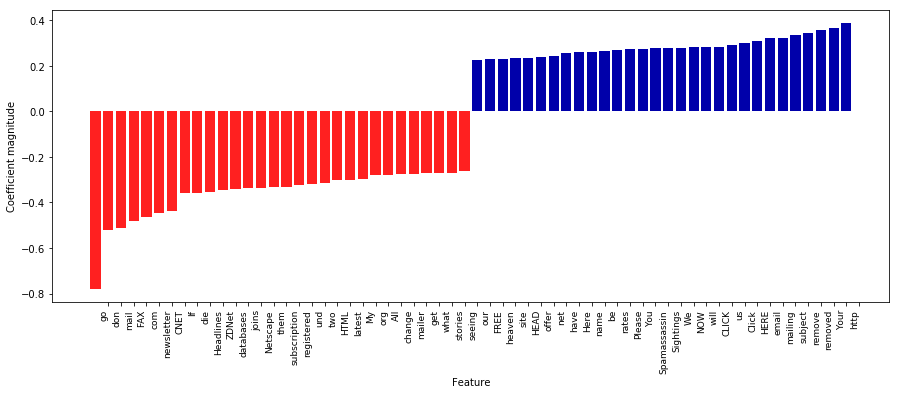

In [60]:
%autoreload 2

from tools import visualize_coefficients

visualize_coefficients(log_clf.coef_, feature_names, n_top_features=30)